In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
YEARS = range(1999, 2025)

In [38]:
'''
data_list = []

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)
    i_data['year'] = i
    data_list.append(i_data)

data = pd.concat(data_list, ignore_index=True, sort=True)

data.to_pickle('nfl_pbp_data.pkl')
data.to_csv('nfl_pbp_data.csv')
'''

data = pd.read_pickle('nfl_pbp_data.pkl')

In [35]:
data

,aborted_play,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,...,xyac_success,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,year,yrdln
0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,NaN,0.0,6.0,0,1999,ARI 30
1,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,NaN,0.0,6.0,10,1999,PHI 23
2,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,NaN,1.0,6.0,10,1999,PHI 23
3,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,76.0,NaN,0.0,6.0,9,1999,PHI 24
4,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,81.0,NaN,10.0,6.0,14,1999,PHI 19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230674,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,64.0,NaN,1.0,7.0,4,2024,WAS 36
1230675,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,63.0,NaN,0.0,7.0,3,2024,WAS 37
1230676,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,NaN,-2.0,-3.0,10,2024,WAS 37
1230677,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,39.0,NaN,-1.0,-3.0,12,2024,WAS 39


In [36]:
def passer_rating(cmp, pass_yds, tds, ints, att):
    a = (cmp/att - .3) * 5
    b = (pass_yds/att - 3) * .25
    c = (tds/att) * 20
    d = 2.375 - (25 * ints/att)

    return ((a+b+c+d)/6) * 100

def anya(pass_yds, tds, ints, sack_yds, sacks, pass_attempts):
    return (pass_yds + (tds * 20) - (ints * 45) - sack_yds)/(pass_attempts + sacks)

In [37]:
#decided to focus on passer rating, ANY/A and EPA as stats.



data['sack_yards'] = np.where(data['sack'] == 1, data['yards_gained'], 0)
game_data = data.groupby(['game_id', 'passer_player_name']).agg({'air_yards' : 'sum', 
                                                                 'yards_after_catch' : 'sum',
                                                                 'yards_gained' : 'sum',
                                                                 'sack_yards' : 'sum',
                                                                 'touchdown' : 'sum',
                                                                 'complete_pass' : 'sum', 
                                                                 'interception' : 'sum', 
                                                                 'pass_attempt' : 'sum', 
                                                                 'sack' : 'sum',
                                                                 'qb_epa' : 'mean'}).reset_index()
sack_data = data[data['sack']==1]
#sack_data

game_data['any/a'] = game_data.apply(lambda row: anya(pass_yds=row['air_yards'], tds=row['touchdown'], ints=row['interception'], sack_yds=row['sack_yards'], sacks=row['sack'], pass_attempts=row['pass_attempt']), axis = 1)
game_data['passer_rating'] = game_data.apply(lambda row: passer_rating(cmp = row['complete_pass'], pass_yds = row['air_yards'], tds = row['touchdown'], ints = row['interception'], att = row['pass_attempt']), axis = 1)

C:\Users\irela\AppData\Local\Temp\ipykernel_19560\2817130754.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['sack_yards'] = np.where(data['sack'] == 1, data['yards_gained'], 0)


<Axes: ylabel='Frequency'>

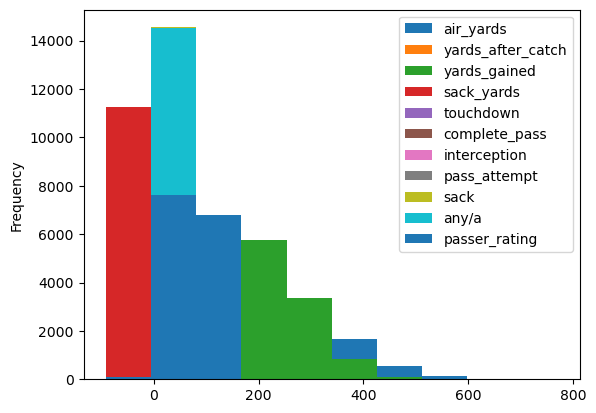

In [42]:
qb_game_data = game_data[game_data['pass_attempt'] > 10]
qb_game_data.plot(kind='hist', x='qb_epa')